# Boston Marathon Challenge

There is a lot of information on runners and their performance for the Boston Marathon. Pick a year (post-2012 has more info) and do some clustering.

Specifically, use the tools at hand to determine which clustering solution, including number of clusters and algorithm used, is best for the marathon data. Once you have a solution you like, write a data story, including visualizations, where you teach the reader something about the Boston Marathon based on your clusters. Write up your report, including your process from start to finish, in a Jupyter notebook and submit it below.

## Data Import and Cleaning
The data was obtained from https://github.com/llimllib/bostonmarathon/blob/master/results/2014/results.csv. It is all the Boston marathon finishing times from the 2014 race, and includes both wheelchair racers and runners. 

During the initial data exploration it was noted that several of the numeric values were identified as objects. These numeric values (race split time) will be converted to floats. Additionally, there were several columns with missing values. The ctz column is missing over 90% of the data. This column will be dropped. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import SpectralClustering
import pandas_profiling

%matplotlib inline

In [2]:
# Import data
df = pd.read_csv('results.csv')
pd.read_csv('results.csv').profile_report()

In [3]:
# Check Datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31984 entries, 0 to 31983
Data columns (total 21 columns):
10k          31984 non-null object
name         31984 non-null object
division     31984 non-null int64
25k          31984 non-null object
gender       31984 non-null object
age          31984 non-null int64
official     31984 non-null float64
bib          31984 non-null object
genderdiv    31984 non-null int64
ctz          1244 non-null object
35k          31984 non-null object
overall      31984 non-null int64
pace         31984 non-null float64
state        29408 non-null object
30k          31984 non-null object
5k           31984 non-null object
half         31984 non-null object
20k          31984 non-null object
country      31984 non-null object
city         31983 non-null object
40k          31984 non-null object
dtypes: float64(2), int64(4), object(15)
memory usage: 5.1+ MB


In [4]:
num = ['5k', '10k', '20k', 'half', '25k', '30k', '40k']

for x in num:
    df[x] = pd.to_numeric(df[x], errors='coerce')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31984 entries, 0 to 31983
Data columns (total 21 columns):
10k          31934 non-null float64
name         31984 non-null object
division     31984 non-null int64
25k          31768 non-null float64
gender       31984 non-null object
age          31984 non-null int64
official     31984 non-null float64
bib          31984 non-null object
genderdiv    31984 non-null int64
ctz          1244 non-null object
35k          31984 non-null object
overall      31984 non-null int64
pace         31984 non-null float64
state        29408 non-null object
30k          31944 non-null float64
5k           31932 non-null float64
half         31912 non-null float64
20k          31933 non-null float64
country      31984 non-null object
city         31983 non-null object
40k          31945 non-null float64
dtypes: float64(9), int64(4), object(8)
memory usage: 5.1+ MB


In [5]:
df.isna().sum()

10k             50
name             0
division         0
25k            216
gender           0
age              0
official         0
bib              0
genderdiv        0
ctz          30740
35k              0
overall          0
pace             0
state         2576
30k             40
5k              52
half            72
20k             51
country          0
city             1
40k             39
dtype: int64

In [6]:
# Drop Columns with large missing data
df.drop(['ctz', 'state', 'overall', 'pace'], axis=1, inplace=True)

# Drop missing rows
df = df.dropna()

df.isna().sum()

10k          0
name         0
division     0
25k          0
gender       0
age          0
official     0
bib          0
genderdiv    0
35k          0
30k          0
5k           0
half         0
20k          0
country      0
city         0
40k          0
dtype: int64

## Data Exploration

In [7]:
# Check the unique number of values for country
num_country = len(np.unique(df['country']))

print('Number of Countries: {}'.format(num_country))

Number of Countries: 78


In [33]:
objects = ['country', 'gender']

for obj in objects:
    temp = {i: j for j, i in enumerate(set(df[obj]))} 
    res = [temp[i] for i in df[obj]] 
    df[obj] = list(res)

# X is the features
X = df.select_dtypes(exclude='object')
print(X.head())
X = normalize(X)

     10k  division    25k  gender  age  official  genderdiv    30k     5k  \
0  17.37         8  47.67       1   47     85.25          8  59.18   8.02   
1  32.58         1  82.43       0   33    138.95          1  99.33  16.22   
2  16.62         1  45.80       1   41     80.60          1  56.45   7.75   
3  32.57         3  82.43       0   24    140.58          3  99.33  16.20   
4  17.12         2  46.37       1   40     81.23          2  57.03   8.02   

    half    20k  country     40k  
0  39.72  37.65       32   80.43  
1  69.47  65.83       62  132.10  
2  38.03  36.10       27   76.10  
3  69.47  65.83       56  132.95  
4  38.60  36.58       32   76.72  


## KMeans

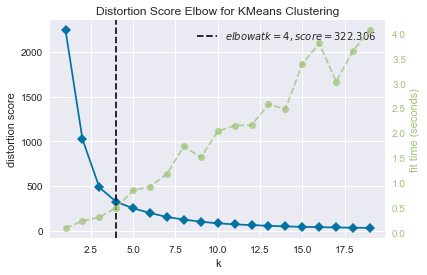

In [9]:
model = KMeans()

# Find the optimal number of clusters for KMeans
vis = KElbowVisualizer(model, k=(1,20))
vis.fit(X)
vis.poof()
plt.show()

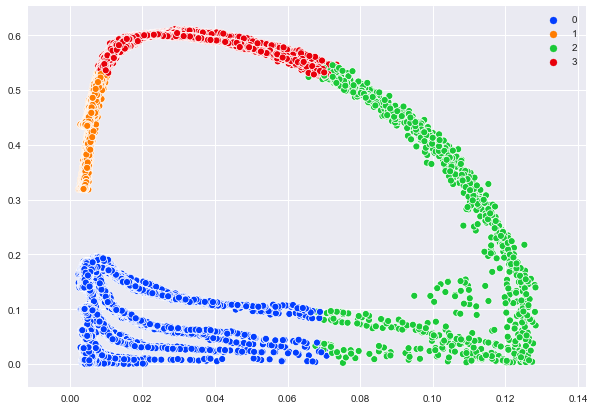

In [31]:
# n is elbow value above
n = vis.elbow_value_
model = KMeans(n_clusters=n).fit_predict(X)

plt.figure(figsize=(10, 7))

pal = sns.color_palette('bright', n)
sns.scatterplot(x=X[:,0], y=X[:,1], hue=model, palette=pal)
plt.show()

## Mean Shift

In [25]:
# Set the bandwidth 
band = estimate_bandwidth(X, quantile=.24, n_samples=500)

# Fit model
model = MeanShift(bandwidth=band, bin_seeding=True)
model.fit(X)

# Extract cluster assignments for each data point
labels = model.labels_

# Coordinates of the cluster centers
centers = model.cluster_centers_

# Count our clusters.
n_clusters = len(np.unique(labels))

print("Number of estimated clusters: {}".format(n_clusters))

Number of estimated clusters: 5


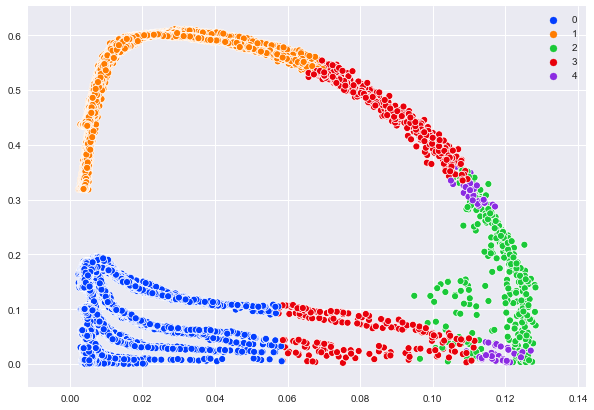

In [30]:
plt.figure(figsize=(10, 7))

pal = sns.color_palette('bright', n_clusters)
sns.scatterplot(x=X[:,0], y=X[:,1], hue=labels, palette=pal)
plt.show()